Rita Miller
August 7, 2022

XGBoost for Binary Classification of Default Prediction

Data overview The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

(Normalization is a multi-step process that puts the data into a tabular form by removing the duplicate data from the relation tables.)

D* = Delinquency variables S = Spend variables P_ = Payment variables B* = Balance variables R* = Risk variables with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

In [ ]:
#Import packages
import numpy as np 
import pandas as pd 
from sklearn.impute import SimpleImputer #or imputing/replacing numerical and categorical missing data

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px 
from itertools import cycle 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

#Modeling
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

#Warnings off and garbage collector
import warnings, gc 
warnings.filterwarnings('ignore')

# change default rows to be displayed 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%time
##Import and Read Data
train = pd.read_feather('/content/drive/MyDrive/AmexFiles/train_data.ftr') #feather version - train data and labels are combined.
#train_labels = pd.read_csv("/content/drive/MyDrive/AmexFiles/train_labels.csv")
#test_data loaded later
#submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')


CPU times: user 8.45 s, sys: 7.46 s, total: 15.9 s
Wall time: 2.83 s


In [ ]:
import pickle
file_name = "/content/drive/MyDrive/AmexFiles/xgb_reg.pkl"

Exploratory Data Analysis

In [ ]:
#train.shape #shape of data set
#train.head() #preview 
#train.info() #summary - has numerical and categorical variables
#train.describe()#summary statistics
#train.describe().T

In [ ]:
##Down-sampled data for exploration and going through first iterations
train = train.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=1)) #using 100% of data

In [ ]:
train.shape

(5531451, 191)

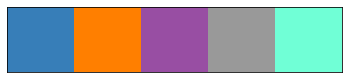

In [ ]:
#Custom Color Blind Palette to View Variables
custom_colors = ["#377eb8","#ff7f00","#984ea3","#999999","#70ffd6"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)

In [ ]:
#Exploration of all Categories of Profile Features
feat_Delinquency = [c for c in train.columns if c.startswith('D_')]
feat_Spend = [c for c in train.columns if c.startswith('S_')]
feat_Payment = [c for c in train.columns if c.startswith('P_')]
feat_Balance = [c for c in train.columns if c.startswith('B_')]
feat_Risk = [c for c in train.columns if c.startswith('R_')]
print(f'Number of Delinquency Variables: {len(feat_Delinquency)}')
print(f'Number of Spend Variables: {len(feat_Spend)}')
print(f'Number of Payment Variables: {len(feat_Payment)}')
print(f'Number of Balance Variables: {len(feat_Balance)}')
print(f'Number of Risk Variables: {len(feat_Risk)}')

Number of Delinquency Variables: 96
Number of Spend Variables: 22
Number of Payment Variables: 3
Number of Balance Variables: 40
Number of Risk Variables: 28


In [ ]:
##Also created a table with this data because a table was better suited for visualization
labels=['Delinquency', 'Spend','Payment','Balance','Risk']
values= [len(feat_Delinquency), len(feat_Spend),len(feat_Payment), len(feat_Balance),len(feat_Risk)]

fig_1 = go.Figure()

fig_1.add_trace(go.Pie(values = values,labels = labels,hole = 0.6, 
                     hoverinfo ='label+percent'))

fig_1.update_traces(textfont_size = 12, hoverinfo ='label+percent',textinfo ='label', 
                  showlegend = False,marker = dict(colors =custom_colors),
                  title = dict(text = 'Feature Distribution'))  

fig_1.show()

In [ ]:
#Exploration of the Distribution of Target Class
target_class = pd.DataFrame({'count': train.target.value_counts(),
                             'percentage': train['target'].value_counts() / train.shape[0] * 100
})
target_class 

,count,percentage
0,4153582,75.090279
1,1377869,24.909721


The target is one and based on the training data, about 25% of customers will likely default in the future.

In [ ]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
del_cols = [c for c in train.columns if (c.startswith(('D','t'))) & (c not in cat_cols)]
df_del = train[del_cols]
spd_cols = [c for c in train.columns if (c.startswith(('S','t'))) & (c not in cat_cols)]
df_spd = train[spd_cols]
pay_cols = [c for c in train.columns if (c.startswith(('P','t'))) & (c not in cat_cols)]
df_pay = train[pay_cols]
bal_cols = [c for c in train.columns if (c.startswith(('B','t'))) & (c not in cat_cols)]
df_bal = train[bal_cols]
ris_cols = [c for c in train.columns if (c.startswith(('R','t'))) & (c not in cat_cols)]
df_ris = train[ris_cols]

In [ ]:
#Second View of Target Class
#Hover over the target class for the percentages of the target class ("0" and "1").
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Pie(values = target_class['count'],labels = target_class.index,hole = 0.6, 
                     hoverinfo ='label+percent'))
fig.update_traces(textfont_size = 12, hoverinfo ='label+percent',textinfo ='label', 
                  showlegend = False,marker = dict(colors =["#ff7f00","#70ffd6"]),
                  title = dict(text = 'Target Distribution'))  
fig.show()

In [ ]:
#Exploration of All Categories of Profile Features
del_cols = [c for c in train.columns if (c.startswith(('D','t'))) & (c not in cat_cols)]
df_del = train[del_cols]
spd_cols = [c for c in train.columns if (c.startswith(('S','t'))) & (c not in cat_cols)]
df_spd = train[spd_cols]
pay_cols = [c for c in train.columns if (c.startswith(('P','t'))) & (c not in cat_cols)]
df_pay = train[pay_cols]
bal_cols = [c for c in train.columns if (c.startswith(('B','t'))) & (c not in cat_cols)]
df_bal = train[bal_cols]
ris_cols = [c for c in train.columns if (c.startswith(('R','t'))) & (c not in cat_cols)]
df_ris = train[ris_cols]

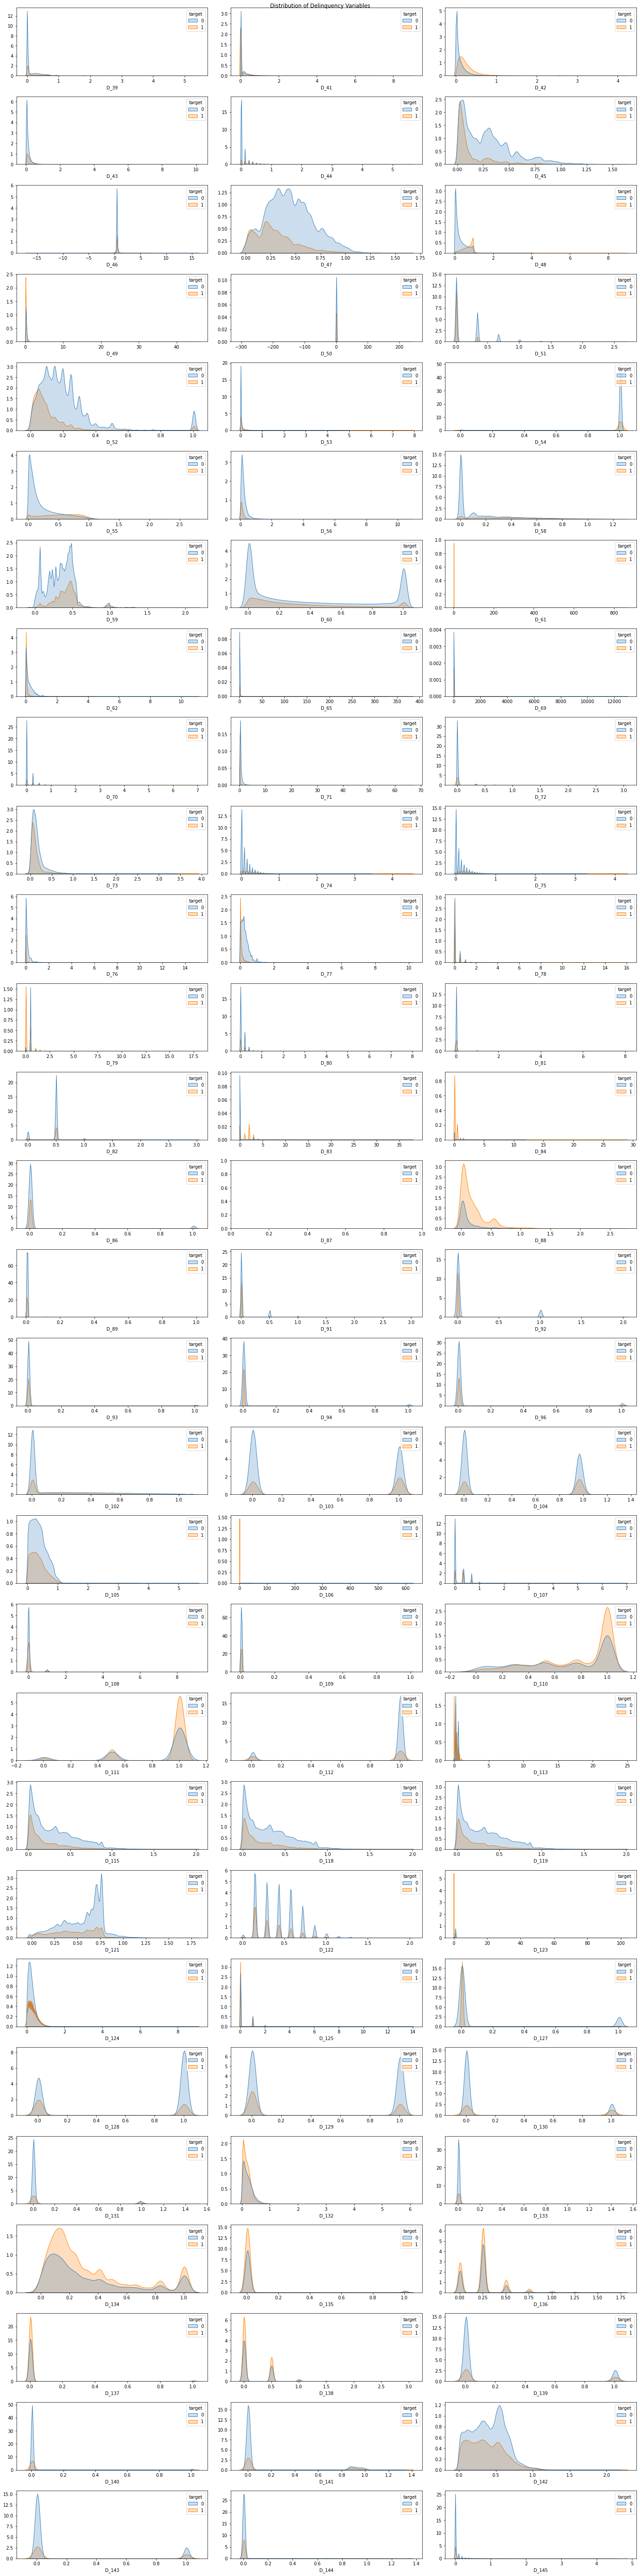

CPU times: user 28min 57s, sys: 17min 39s, total: 46min 37s
Wall time: 26min 34s


In [ ]:
%%time
#Distribution of All Delinquency Variables 
fig, axes = plt.subplots(29, 3, figsize = (20,80))
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(del_cols) - 1:
        sns.kdeplot(x = del_cols[i], hue='target', data = df_del, fill = True, ax = ax, palette =["#377eb8","#ff7f00"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
fig.suptitle('Distribution of Delinquency Variables', fontsize = 12, x = 0.5, y = 1)
plt.tight_layout()
plt.show()

In [ ]:
#Explore correlations
def get_correlated_features(corr, threshold=0.5):
  '''
  Gives the features which are correlated more than threshold and considers absolute value
  '''
  corr_df = corr.mask(np.triu(np.ones_like(corr, dtype = bool))).abs().unstack().sort_values(ascending=False).reset_index().rename(columns={
    'level_0': 'feature1',
    'level_1': 'feature2',
    0: 'correlation'
  })

  return corr_df[corr_df['correlation'] >= threshold]

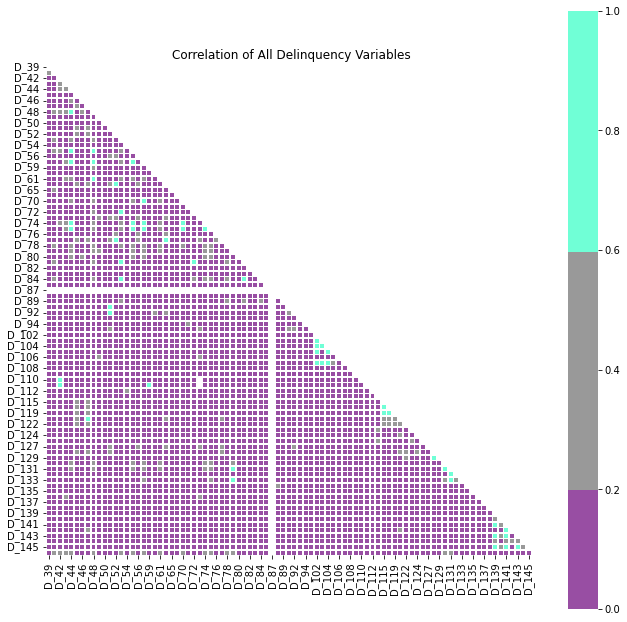

CPU times: user 1min 30s, sys: 3.02 s, total: 1min 33s
Wall time: 1min 32s


In [ ]:
%%time
#Correlation of all Delinquency Variables
plt.figure(figsize =(11,11))
corr = df_del.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, vmin=0, vmax=1, cmap = custom_colors)
plt.title('Correlation of All Delinquency Variables')
plt.show()

In [ ]:
%%time
# Get the features that are highly correlated
get_correlated_features(corr, threshold=0.6)

CPU times: user 6.91 ms, sys: 1.45 ms, total: 8.36 ms
Wall time: 7.55 ms


,feature1,feature2,correlation
0,D_62,D_77,0.999780
1,D_103,D_104,0.999750
2,D_139,D_143,0.999498
3,D_139,D_141,0.998168
4,D_141,D_143,0.997691
5,D_118,D_119,0.994915
6,D_74,D_75,0.987642
7,D_58,D_75,0.925890
8,D_58,D_74,0.922569
9,D_131,D_132,0.879993


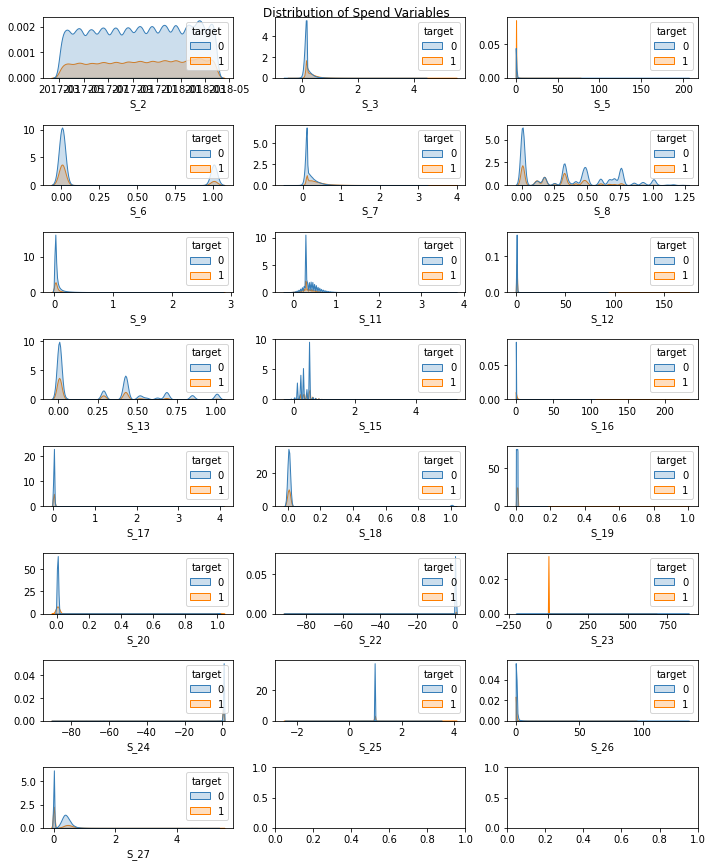

CPU times: user 8min 15s, sys: 4min 42s, total: 12min 58s
Wall time: 7min 37s


In [ ]:
%%time
#Distribution of Spend Variables
fig, axes = plt.subplots(8, 3, figsize = (10,12))
fig.suptitle('Distribution of Spend Variables', fontsize = 12, x = 0.5, y = 1)
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(spd_cols) - 1:
        sns.kdeplot(x = spd_cols[i], hue ='target', data = df_spd, fill = True, ax = ax, palette =["#377eb8","#ff7f00"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

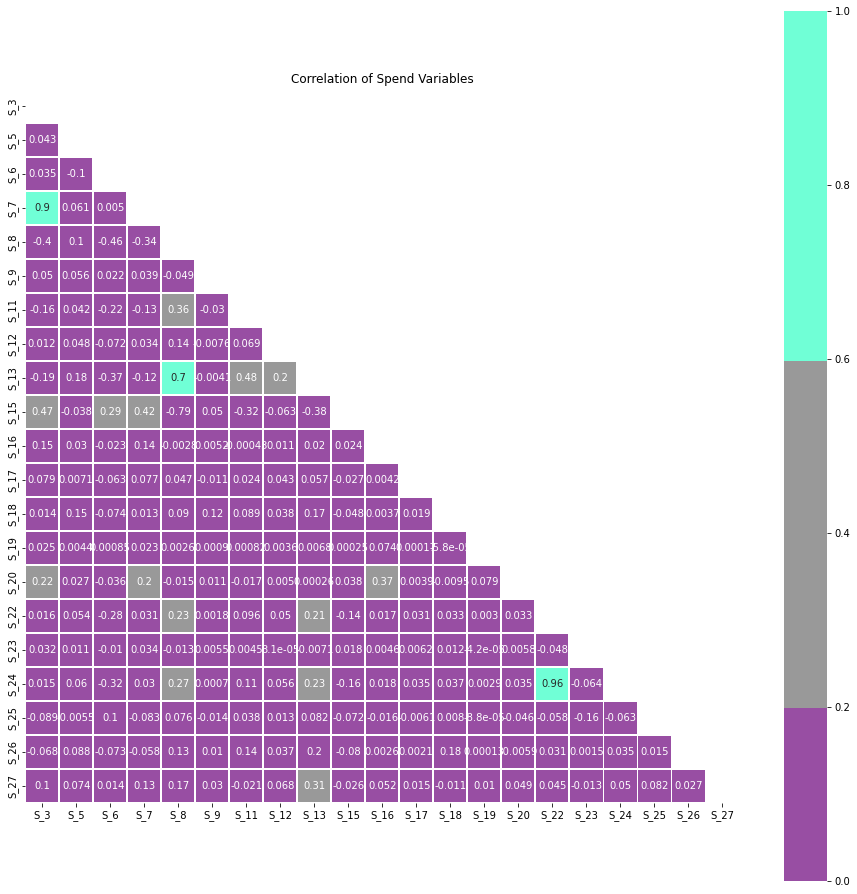

CPU times: user 8.54 s, sys: 284 ms, total: 8.82 s
Wall time: 8.51 s


In [ ]:
%%time
#Correlation Spend Variables
S_cols = [c for c in train.columns if (c.startswith(('S')))]
df_S = train[S_cols]

# setting the parameter values
annot = True 
plt.figure(figsize = (16,16))
corr = df_S.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0, square = True, linewidths = .6, vmin=0, vmax=1, annot=annot,cmap = custom_colors)
plt.title('Correlation of Spend Variables')
plt.show()

In [ ]:
# Get the features which are highly correlated
get_correlated_features(corr, threshold=0.6)

,feature1,feature2,correlation
0,S_22,S_24,0.959319
1,S_3,S_7,0.904635
2,S_8,S_15,0.786853
3,S_8,S_13,0.695414


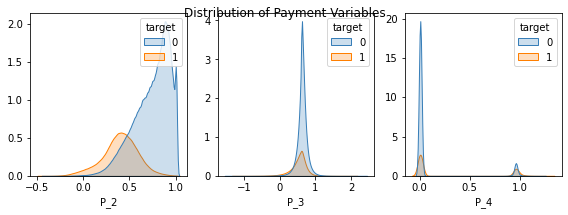

CPU times: user 1min 16s, sys: 39.8 s, total: 1min 56s
Wall time: 1min 10s


In [ ]:
%%time
#Distribution of Payment Variables
fig, axes = plt.subplots(1, 3, figsize = (8,3))
fig.suptitle('Distribution of Payment Variables',fontsize = 12)
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(pay_cols) - 1:
        sns.kdeplot(x = pay_cols[i], hue ='target', data = df_pay, fill = True, ax = ax, palette =["#377eb8","#ff7f00"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

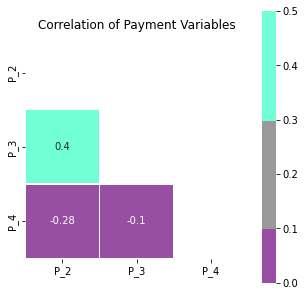

CPU times: user 469 ms, sys: 188 ms, total: 657 ms
Wall time: 445 ms


In [ ]:
%%time
#Correlation of Payment Variables, Figure 1
P_cols = [c for c in train.columns if (c.startswith(('P')))]
df_P = train[P_cols]

# setting the parameter values
annot = True 

plt.figure(figsize = (5,5))
corr = df_P.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths = .6, vmin=0, vmax=.5, annot=annot, cmap = custom_colors)
plt.title('Correlation of Payment Variables')
plt.show()

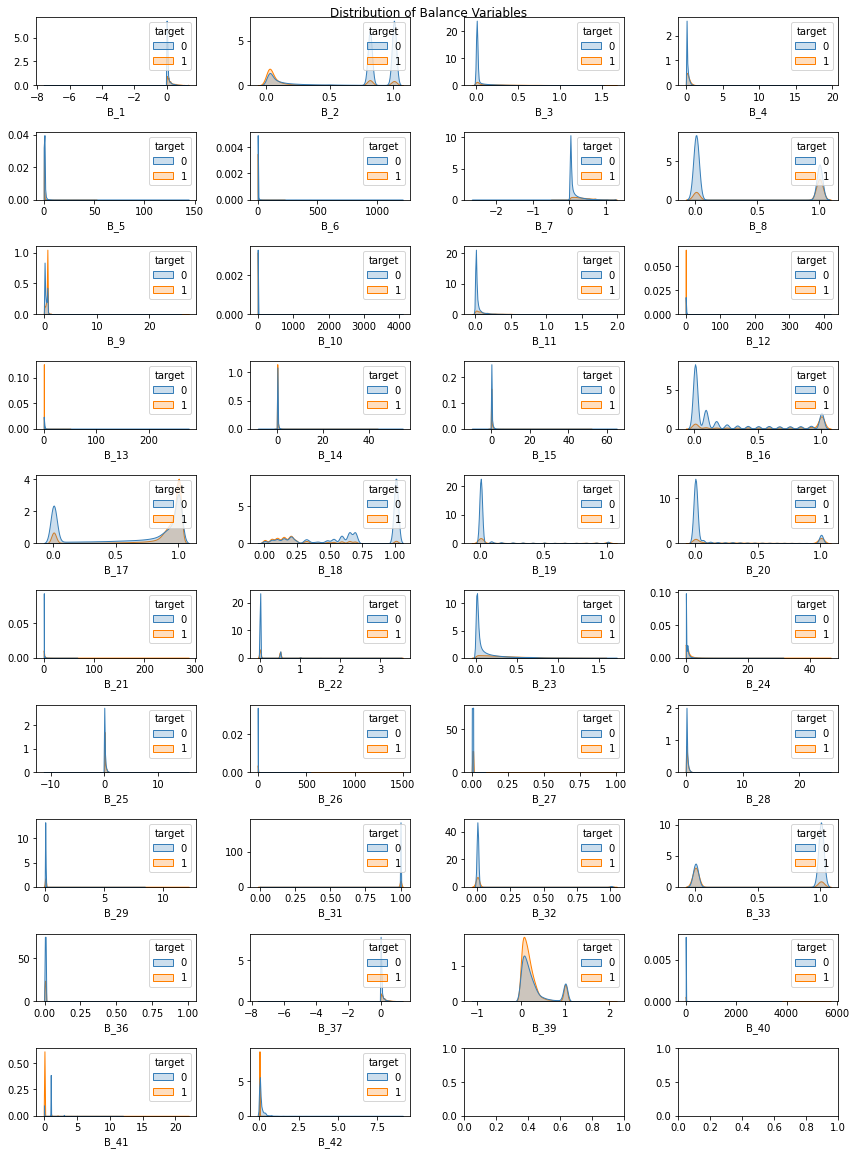

CPU times: user 14min 20s, sys: 8min 12s, total: 22min 32s
Wall time: 13min 12s


In [ ]:
%%time
#Distribution of Balance Variables
fig, axes = plt.subplots(10, 4, figsize = (12,16))
fig.suptitle('Distribution of Balance Variables',fontsize = 12, x = 0.5, y = 1)
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(bal_cols) - 1:
        sns.kdeplot(x = bal_cols[i], hue ='target', data = df_bal, fill = True, ax = ax, palette =["#377eb8","#ff7f00"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

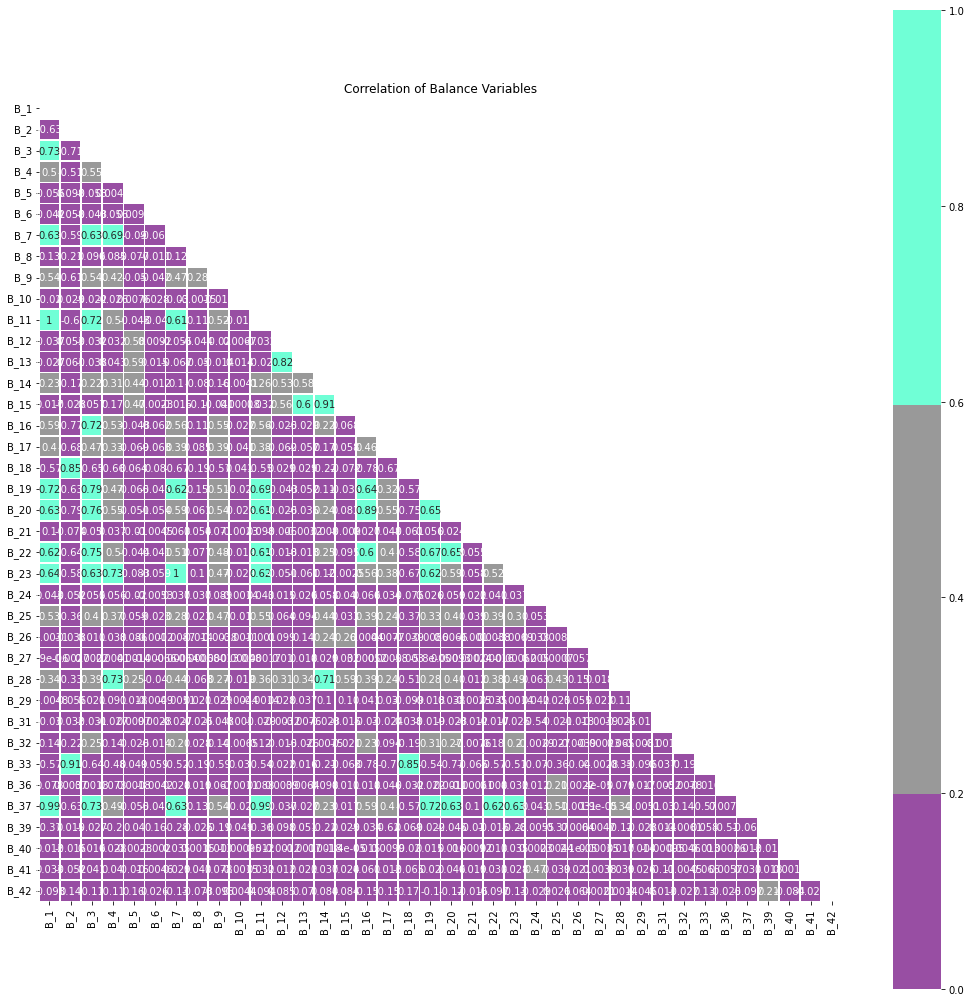

CPU times: user 22.4 s, sys: 418 ms, total: 22.8 s
Wall time: 22.4 s


In [ ]:
%%time
#Correlation of Balance Variables
B_cols = [c for c in train.columns if (c.startswith(('B')))]
df_B = train[B_cols]

# setting the parameter values
annot = True 
plt.figure(figsize = (18,18))
corr = df_B.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust=True, center = 0,square = True, annot=annot, linewidths =.6, vmin=0, vmax=1, cmap = custom_colors)
plt.title('Correlation of Balance Variables')
plt.show()

In [ ]:
# Get the features which are highly correlated
get_correlated_features(corr, threshold=0.6)

,feature1,feature2,correlation
0,B_1,B_11,0.995574
1,B_7,B_23,0.995051
2,B_1,B_37,0.992915
3,B_11,B_37,0.987941
4,B_2,B_33,0.912814
5,B_14,B_15,0.909885
6,B_16,B_20,0.888474
7,B_18,B_33,0.853171
8,B_2,B_18,0.849712
9,B_12,B_13,0.820876


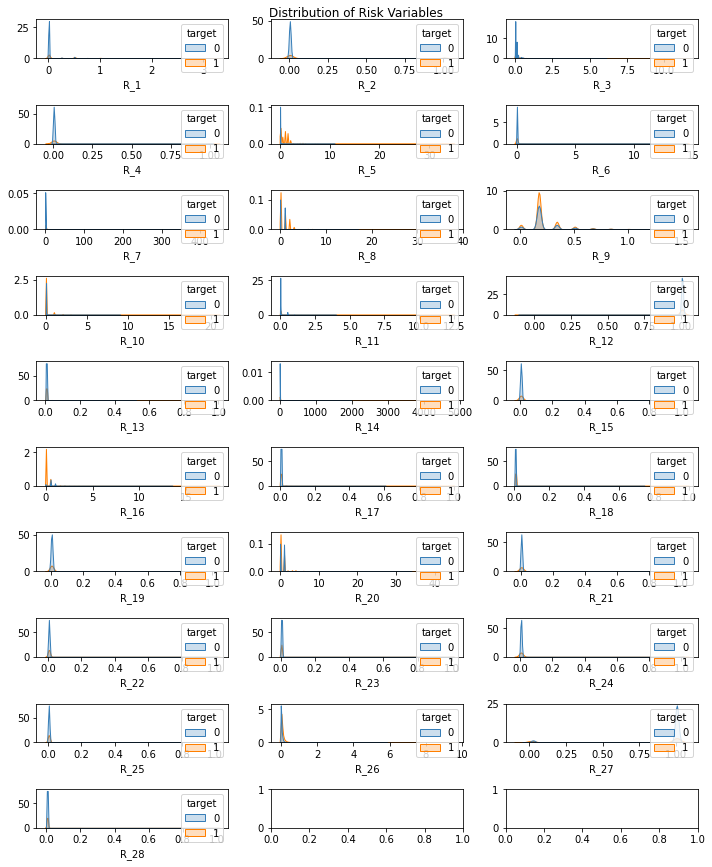

CPU times: user 10min 18s, sys: 6min 7s, total: 16min 25s
Wall time: 9min 28s


In [ ]:
%%time
#Distribution of Risk Variables
fig, axes = plt.subplots(10, 3, figsize = (10,12))
fig.suptitle('Distribution of Risk Variables',fontsize=12, x = 0.5, y = 1)
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(ris_cols) - 1:
        sns.kdeplot(x = ris_cols[i], hue ='target', data = df_ris, fill = True, ax = ax, palette =["#377eb8","#ff7f00"])
        ax.tick_params()
        ax.xaxis.get_label()
        ax.set_ylabel('')
plt.tight_layout()
plt.show()

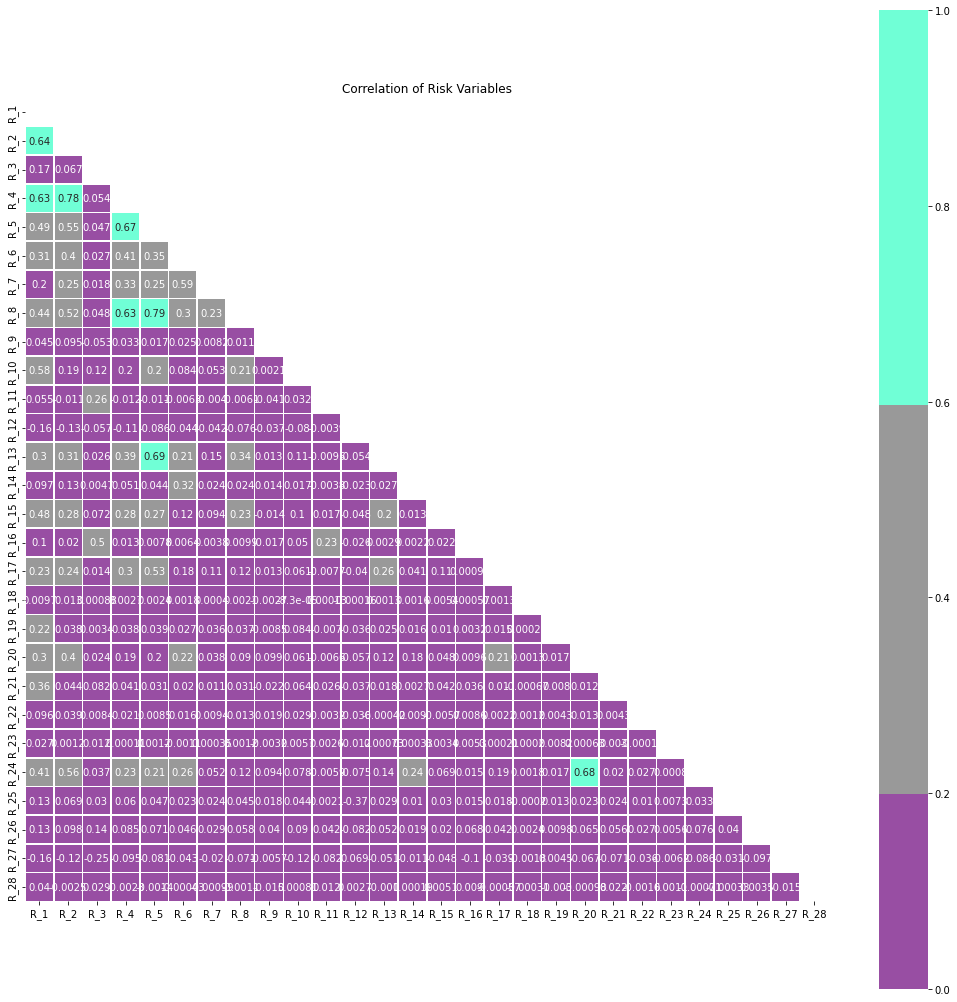

CPU times: user 16 s, sys: 412 ms, total: 16.4 s
Wall time: 15.9 s


In [ ]:
%%time
#Correlation of Risk Variables
R_cols = [c for c in train.columns if (c.startswith(('R')))]
df_R = train[R_cols]

# setting the parameter values
annot = True 
plt.figure(figsize=(18,18))
corr = df_R.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0, square = True, annot=annot, linewidths =.6, vmin=0, vmax=1, cmap = custom_colors)
plt.title('Correlation of Risk Variables')
plt.show()

In [ ]:
# Get the features which are highly correlated
get_correlated_features(corr, threshold=0.6)

,feature1,feature2,correlation
0,R_5,R_8,0.791508
1,R_2,R_4,0.778281
2,R_5,R_13,0.686478
3,R_20,R_24,0.678946
4,R_4,R_5,0.672136
5,R_1,R_2,0.637846
6,R_1,R_4,0.629041
7,R_4,R_8,0.626703


In [ ]:
#Correlation of Variables with the Target
palette = cycle(["#377eb8","#ff7f00","#984ea3","#999999","#70ffd6"])
targ = train.corrwith(train['target'], axis=0)
val = [str(round(v ,1) *100) + '%' for v in targ.values]
fig = go.Figure()
fig.add_trace(go.Bar(y=targ.index, x= targ.values, orientation='h',text = val, marker_color = next(palette)))
fig.update_layout(title = "Correlation of Variables with the Target",width = 360, height = 1800)

In [ ]:
gc.collect()

445

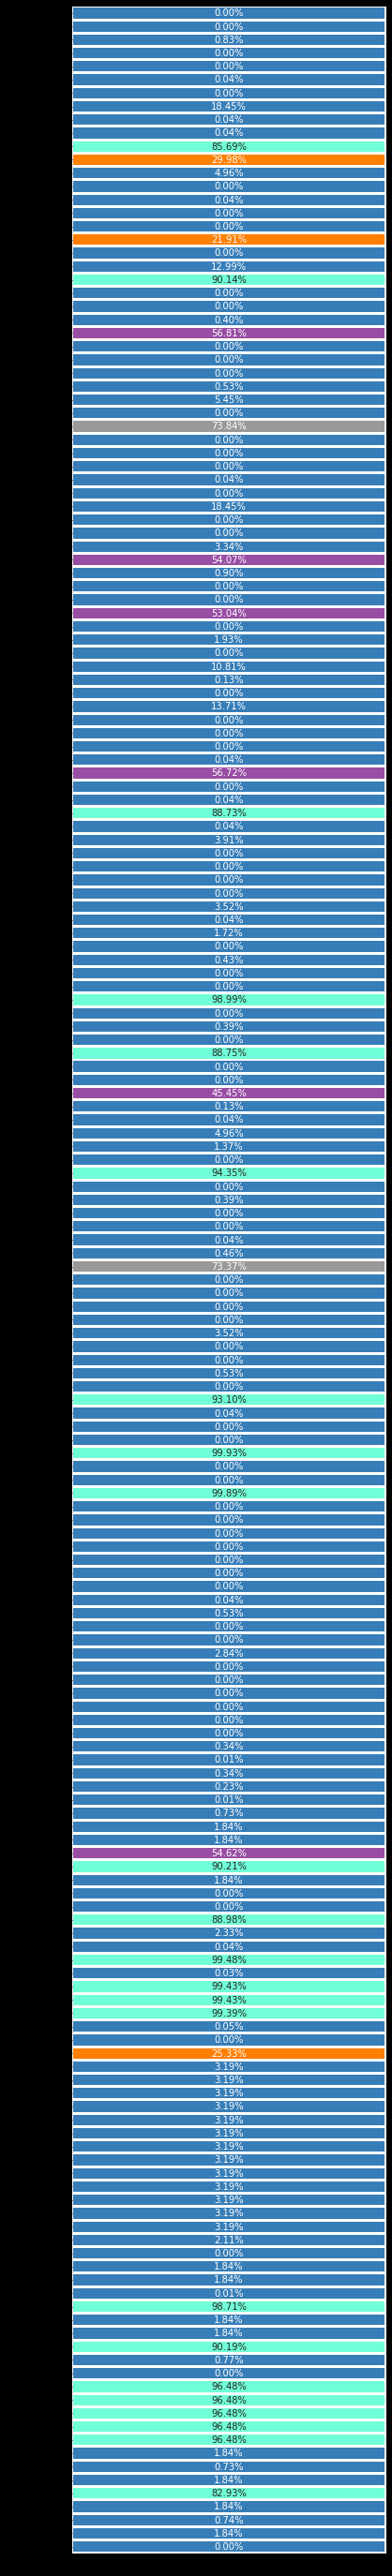

CPU times: user 7.78 s, sys: 494 ms, total: 8.27 s
Wall time: 7.86 s


In [ ]:
%%time
#Exploration of Missing Values
background_color = 'black'
missing = pd.DataFrame(columns = ['% Missing values'],data = train.isnull().sum()/len(train))
fig = plt.figure(figsize = (15, 50),facecolor=background_color)
gs = fig.add_gridspec(1, 2)
gs.update(wspace = 0.5, hspace = 0.5)
ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top", "bottom", "left"]:
    ax0.spines[s].set_visible(False)
sns.heatmap(missing,cbar = False,annot = True,fmt =".2%", linewidths = 2,cmap = custom_colors,vmax = 1, ax = ax0)
plt.show()

In [ ]:
#Finding the percentage of missing values
tmp = train.isna().sum().mul(100).div(len(train)).sort_values(ascending=False)
tmp

D_87           99.930127
D_88           99.891457
D_108          99.476846
D_111          99.433530
D_110          99.433530
B_39           99.391986
D_73           98.990211
B_42           98.707789
D_136          96.480146
D_138          96.480146
D_137          96.480146
D_135          96.480146
D_134          96.480146
R_9            94.349891
B_29           93.104594
D_106          90.213255
D_132          90.191055
D_49           90.137597
R_26           88.984717
D_76           88.746226
D_66           88.730733
D_42           85.694278
D_142          82.926577
D_53           73.842921
D_82           73.373406
D_50           56.809723
B_17           56.722874
D_105          54.622756
D_56           54.071581
S_9            53.035686
D_77           45.447605
D_43           29.981211
S_27           25.326718
D_46           21.905627
S_7            18.449843
S_3            18.449843
D_62           13.706367
D_48           12.993426
D_61           10.811847
P_3             5.450505


In [ ]:
# Drop columns with missing values >70%
missingDF = pd.DataFrame(tmp).reset_index()
drop_cols = missingDF[missingDF[0]>70]["index"].values
print(drop_cols)

['D_87' 'D_88' 'D_108' 'D_111' 'D_110' 'B_39' 'D_73' 'B_42' 'D_136'
 'D_138' 'D_137' 'D_135' 'D_134' 'R_9' 'B_29' 'D_106' 'D_132' 'D_49'
 'R_26' 'D_76' 'D_66' 'D_42' 'D_142' 'D_53' 'D_82']


In [ ]:
##Save the preprocessing and model in one list to dump in pickle and reapply at later point in time
processing = {}
processing['drop_cols'] = drop_cols

In [ ]:
train.drop(columns = drop_cols,axis=1, inplace=True)

In [ ]:
# For categorical columns
cols = train.columns
num_cols = train._get_numeric_data().columns
categorical_columns = list(set(cols) - set(num_cols))

# We don't want to observe the datetime column and customer id as they will have too many unique values anyways
filtered_categorical_columns = list(set(train[categorical_columns])-{"S_2","customer_ID"})

In [ ]:
## check if there are too many unique values(>10-15) in categorical columns which will make them difficult to train with models
train[filtered_categorical_columns].nunique()

D_120    2
D_68     7
D_114    2
B_30     3
D_64     5
D_117    7
D_116    2
D_126    3
B_38     7
D_63     6
dtype: int64

No column seen that has too many unique values so will keep all the categorical columns

In [ ]:
## Let's make sure that these categorical columns don't have too many missing values (>30-50%)
train[filtered_categorical_columns].isna().sum().mul(100).div(len(train))

D_120    3.194749
D_68     3.914036
D_114    3.194749
B_30     0.036446
D_64     0.000000
D_117    3.194749
D_116    3.194749
D_126    2.111851
B_38     0.036446
D_63     0.000000
dtype: float64

In [ ]:
# Finally, let's see the distribution of the labels in categorical columns
for i in filtered_categorical_columns:
    print(train.groupby('target')[i].value_counts(normalize=True))

target     
0       0.0    0.918463
        1.0    0.081537
1       0.0    0.773596
        1.0    0.226404
Name: D_120, dtype: float64
target     
0       6.0    0.570093
        5.0    0.220173
        4.0    0.077784
        3.0    0.075818
        2.0    0.033185
        1.0    0.019703
        0.0    0.003244
1       6.0    0.377909
        5.0    0.244626
        3.0    0.139067
        4.0    0.127288
        2.0    0.067138
        1.0    0.041750
        0.0    0.002222
Name: D_68, dtype: float64
target     
0       1.0    0.671197
        0.0    0.328803
1       0.0    0.542259
        1.0    0.457741
Name: D_114, dtype: float64
target     
0       0.0    0.926411
        1.0    0.068479
        2.0    0.005110
1       0.0    0.627341
        1.0    0.348262
        2.0    0.024397
Name: B_30, dtype: float64
target    
0       O     0.582669
        U     0.240892
        R     0.138500
              0.030958
        -1    0.006980
1       U     0.379486
        O     0.35785

In [ ]:
train.drop(columns=['D_116'], inplace=True)
filtered_categorical_columns.remove('D_116')

In [ ]:
%%time
## Remainder of the categorical columns
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy="most_frequent")
transformed_df = pd.DataFrame(imputer.fit_transform(train[filtered_categorical_columns]),columns = filtered_categorical_columns)

CPU times: user 11.8 s, sys: 2.11 s, total: 13.9 s
Wall time: 13.8 s


In [ ]:
processing['categorical_imputer'] = imputer

In [ ]:
train[filtered_categorical_columns] = transformed_df[filtered_categorical_columns]

In [ ]:
# Fill with the medians
numeric_columns = train.select_dtypes(np.number).columns.drop('target')
numerical_fill_na_with_median = train[numeric_columns].median()
train[numeric_columns] = train[numeric_columns].fillna(numerical_fill_na_with_median)

In [ ]:
processing['numerical_fill_na_with_median'] = numerical_fill_na_with_median

# Summary of categorical data
- All columns except date(S_2) and customer_id don't have too many unique values
- Don't see many missing values, so lets now process and fill the missing data with the midpoint of the frequency distribution of observed values  in those columns
- For column `D_116` irrespecitve of value the distributed of target label so we can drop that one 

In [ ]:
# Handling date column lets extract different components and let tree models decide which part works the best
train["S_2_day"] = train["S_2"].dt.day
train["S_2_month"] = train["S_2"].dt.month
train["S_2_year"] = train["S_2"].dt.year

In [ ]:
# Considering only one data point per customer 
train = train.groupby(['customer_ID']).nth(-1).reset_index(drop=True)

In [ ]:
train.shape

(458913, 167)

In [ ]:
# drop S_2, since it is not relevant for prediction purposes 
train.drop(columns=["S_2"], axis=1, inplace=True)

In [ ]:
# converting pandas "categorical" dtype to numeric
numeric_categorical_encoded_cols = list(set(filtered_categorical_columns) - set(['D_63', 'D_64']))
train[numeric_categorical_encoded_cols] = train[numeric_categorical_encoded_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
processing['numeric_categorical_encoded_cols'] = numeric_categorical_encoded_cols

# Modeling 



In [ ]:
X = train.drop(columns=["target"],axis=1)
y = train["target"]

In [ ]:
# split X and y into training and testing sets, 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=100)

In [ ]:
# Describes info about train and test set
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (367130, 165)
Number transactions y_train dataset:  (367130,)
Number transactions X_test dataset:  (91783, 165)
Number transactions y_test dataset:  (91783,)


In [ ]:
# Label encoding
categorical_columns = ["D_63","D_64"]

oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-999)
oe.fit(X_train[categorical_columns])

X_train_enc = oe.transform(X_train[categorical_columns])
X_test_enc = oe.transform(X_test[categorical_columns])

X_train[categorical_columns] = X_train_enc
X_test[categorical_columns] = X_test_enc

In [ ]:
processing['one_hot_encoder'] = oe

In [ ]:
train['target'].value_counts() #the target is imbalanced

0    340085
1    118828
Name: target, dtype: int64

Build the model using decision tree classifier
making predictions using XGBoost

In [ ]:
%%time
#Declare parameters and train the XGBoost Classifier
xgb_classifier = XGBClassifier(objective='binary:logistic', #Learning task parameter - logistic regression for binary classification, returns predicted probability (not class)
                      n_estimators=1000, #general parameter

                      eta=0.3, #Boost parameter, this is the learning rate (default = .3), step size shrinkage used in update to prevent overfitting
                      seed=12,
                      use_label_encoder=False,
                      eval_metric='aucpr',  
                      scale_pos_weight= 0.250672 / 0.749328, # tells the model the distribution of the data
                      max_delta_step = 1, #predicting the right probability, in such a case, you cannot re-balance the dataset
                      early_stopping_rounds=20, #stop training when the loss on validation dataset starts increasing (in the case of minimizing the loss). 
                      tree_method='auto', #Equivalent to the XGBoost fast histogram algorithm. Much faster and uses considerably less memory, changed from "gpu_hist" to auto: Use heuristic to choose the fastest method.
                      enable_categorical=True)
xgb_classifier.fit(X_train, y_train) #fit classifier to the training data
             

CPU times: user 35min 47s, sys: 16.9 ms, total: 35min 47s
Wall time: 35min 39s


Three types of parameters should be chosen before running XGBoost: General, booster, and task parameters. The output highlights the parameters used by the model to achieve the best solution when making a prediction. 

After XGBoost 1.6, both of the requirements and restrictions for using area under the curve precision recall (aucpr) in classification problem are similar to auc. For ranking task, only binary relevance label is supported. Different from map (mean average precision), aucpr calculates the interpolated area under precision recall curve using continuous interpolation.

scale_pos_weight [default=1], It controls the balance of positive and negative weights,
It is useful for imbalanced classes.
A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence. A typical value to consider: sum(negative instances) / sum(positive instances).

In [ ]:
#Test the model using the test data set. This allows us to check the performance of the model after the training phase. Makes predictions on test data with XGBoost Classifier 
y_pred = xgb_classifier.predict(X_test) 
y_pred

array([0, 0, 0, ..., 0, 0, 0])

For the first value in the array, the model has made a prediction of 0 - which shows the target of 0 or 0 probability of a future payment. 

In [ ]:
#define metrics
y_pred_prob = xgb_classifier.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

In [ ]:
y_test = pd.DataFrame(y_test, columns=["target"])
y_pred = pd.DataFrame(y_pred, columns=["prediction"])
y_pred_prob = pd.DataFrame(y_pred_prob, columns=["prediction"])

In [ ]:
# Compute accuracy
accuracy = metrics.accuracy_score(y_test["target"], y_pred["prediction"]) 
print(f'The Accuracy of the Model is: {accuracy: .2%}')

The Accuracy of the Model is:  84.03%


This  shows the model has an accuracy score of 84% when making predictions. 

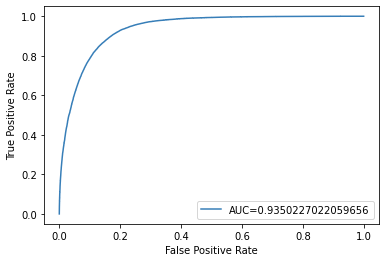

In [ ]:
#Create ROC Curve
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#Precision Metric

Sensitivity: The probability that the model predicts a positive outcome for an observation when it indeed the outcome is positive. This is also called the "true positive rate."
Specificity: The probability that the model predicts a negative outcome for an observation when indeed the outcome is negative. This is also called the "true negative rate." Both metrics can be visualized in a receiver operating characteristic (ROC) curve. The ROC curve is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. 

#The AUC tells us how much of the plot is located under the curve. The closer the AUC is to 1, the better the model. In the plot, the curve hugs to the top left of the plot. The better the model does at classifying the data into categories. As observed above, the XGB model does a good job of classifying the data into categories. The AUC for this XGB classifier is 0.935.

In [ ]:
gc.collect()

8715

In [ ]:
#Hyperparameter tuning in XGBoost-Quantifying the quality of predictions

#General parameters
estimator = XGBClassifier(
    objective= 'binary:logistic', 

    #Boost parameters
    eta = 0.3,
    min_child_weight = 1, #default is 1 - min number of observations
    gamma = 0,
    subsample=1,
    colsample_bytree=.8,
    scale_pos_weight=1, #due to high class imbalance
    max_depth = 6, #default is 6 - max depth of a tree, used to control over-fitting
    alpha = 0, #default is 0 - can be used in high dimensionality so that algorithm runs faster
    nthread=4, #number of threads to speed up the training, used for parallel processing, if not set it will run on all cores and the algorithm will detect automatically
    #other parameters will be selected automatically by XGBoost and run on default
    
    #Task parameters
    use_label_encoder=False,
    eval_metric='aucpr',  
    seed=123) #seed is the random generator

In [ ]:
parameters = {       #Configure the Gridsearch CV object to choose the best parameter using aucpr metric to compare results of 10-fold CV
    'max_depth': range (4, 10, 2), #tunable parameters and the range of values
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc', #Quantifying quality of prediction for binary targets, performance of the selected hyper parameters and trained model is measured on a dedicated evaluation set that was not used during the model selection step
    n_jobs = 10,
    cv = 10, #cross-validation at each boosting iteration and thus returns the optimal number of trees required
    verbose=True
)

In [ ]:
%%time
grid_search.fit(X_train, y_train) #Train the scikit-learn model. 

Fitting 10 folds for each of 36 candidates, totalling 360 fits
CPU times: user 12min 22s, sys: 15.7 s, total: 12min 38s
Wall time: 2h 24min 59s


GridSearchCV(cv=10,
             estimator=XGBClassifier(alpha=0, colsample_bytree=0.8, eta=0.3,
                                     eval_metric='aucpr', max_depth=6,
                                     nthread=4, seed=123,
                                     use_label_encoder=False),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(4, 10, 2),
                         'n_estimators': range(60, 220, 40)},
             scoring='roc_auc', verbose=True)

In [ ]:
#The best_estimator field contains the best model trained by GridSearch
processing['model'] = grid_search.best_estimator_
#save
pickle.dump(processing, open(file_name, "wb"))

In [ ]:
grid_search.best_estimator_

XGBClassifier(alpha=0, colsample_bytree=0.8, eta=0.3, eval_metric='aucpr',
              max_depth=6, n_estimators=180, nthread=4, seed=123,
              use_label_encoder=False)

In [ ]:
best_model = grid_search.best_estimator_ #best model trained by GridSearch
best_model

XGBClassifier(alpha=0, colsample_bytree=0.8, eta=0.3, eval_metric='aucpr',
              max_depth=6, n_estimators=180, nthread=4, seed=123,
              use_label_encoder=False)

In [ ]:
y_pred = best_model.predict(X_test)

The Quality of the Prediction is:  87.04%


Text(0.5, 0, 'Feature Importance Score')

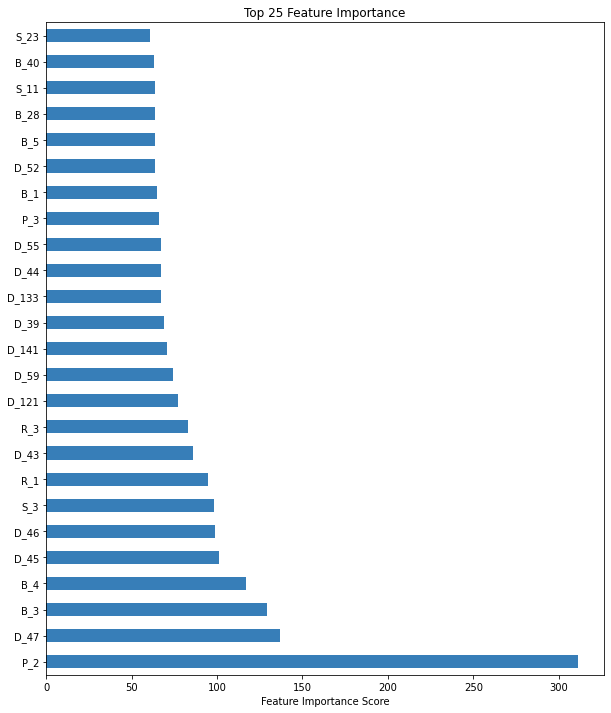

In [ ]:
# Compute quality of the prediction
accuracy = metrics.accuracy_score(y_test["target"], y_pred)
print(f'The Quality of the Prediction is: {accuracy: .2%}')

#Feature Importance
feat_imp = pd.Series(xgb_classifier.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.head(25).plot(kind='barh', title='Top 25 Feature Importance',figsize=(10,12))
plt.xlabel('Feature Importance Score')

Figure 4: Feature Importance

Model Performance - Testing of model on the test dataset

In [ ]:
# load
processing = pickle.load(open(file_name, "rb"))

In [ ]:
drop_cols = processing['drop_cols']

In [ ]:
processing.keys()

dict_keys(['drop_cols', 'categorical_imputer', 'numerical_fill_na_with_median', 'numeric_categorical_encoded_cols', 'one_hot_encoder', 'model'])

In [ ]:
filtered_categorical_columns = ['D_64', 'B_30', 'D_120', 'D_117', 'D_126', 'D_114', 'D_63', 'D_68', 'B_38'] # processing['filtered_categorical_columns']

imputer = processing['categorical_imputer']

# fill numerical data
numerical_fill_na_with_median = processing['numerical_fill_na_with_median']
numeric_columns = numerical_fill_na_with_median.index.tolist()



In [ ]:
numeric_categorical_encoded_cols = processing['numeric_categorical_encoded_cols']

categorical_columns = ["D_63","D_64"]

oe = processing['one_hot_encoder']

xgb_classifier = processing['model']

In [ ]:
test_main = pd.read_feather('/content/drive/MyDrive/AmexFiles/test.feather')

In [ ]:
test_main.shape

(11363762, 190)

In [ ]:
def test_pred(test):
  
  ## for rest of the categorical columns
  transformed_df = pd.DataFrame(imputer.transform(test[filtered_categorical_columns]),columns = filtered_categorical_columns)
  test[filtered_categorical_columns] = transformed_df[filtered_categorical_columns]

  # Lets also fill the median
  test[numeric_columns] = test[numeric_columns].fillna(numerical_fill_na_with_median)

  # dealing with S_2 date time column
  test['S_2'] = pd.to_datetime(test['S_2'])

  # Handling date column lets extract different components and let tree models decide which part works the best
  test["S_2_day"] = test["S_2"].dt.day
  test["S_2_month"] = test["S_2"].dt.month
  test["S_2_year"] = test["S_2"].dt.year

  # drop S_2
  test = test.drop(columns=["S_2"], axis=1)

  test[numeric_categorical_encoded_cols] = test[numeric_categorical_encoded_cols].apply(pd.to_numeric, errors='coerce')
  try:
    test_enc = oe.transform(test[categorical_columns])
    test[categorical_columns] = test_enc
  except:
    pass
  
  final_test = test[xgb_classifier.get_booster().feature_names]

  return xgb_classifier.predict(final_test)

In [ ]:
%%time
test_results = np.array([])
indices = list( range(0, len(test_main), int(len(test_main)/ 20)))
for i in range(len(indices)-1):
  test_slice = test_main.iloc[indices[i]: indices[i+1]]
  test_result = test_pred(test_slice)
  test_results = np.append(test_results, test_result)
  gc.collect()
# for final chunk
test_result = test_pred(test_main.iloc[indices[-1]:])
test_results = np.append(test_results, test_result)


CPU times: user 3min 3s, sys: 2.25 s, total: 3min 5s
Wall time: 1min 37s


In [ ]:
results = test_main[['customer_ID']]
results['prediction'] = test_results

In [ ]:
#save to sample submission.csv
results.to_csv('/content/drive/MyDrive/AmexFiles/test_results.csv')

In [ ]:
results.shape

(11363762, 2)

In [ ]:
results = test_main[['customer_ID']]
results['prediction'] = test_results

In [ ]:
results = results.groupby(['customer_ID']).nth(-1).reset_index()

In [ ]:
#save to sample submission.csv
results.to_csv('/content/drive/MyDrive/AmexFiles/submission.csv', index=False)

In [ ]:
results.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.0
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.0
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.0
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.0
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.0


# New Section

In [ ]:
results.shape 

(924621, 2)